In [2]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import seaborn as sns
sns.set_style("whitegrid")

### Camera calibration pipeline

In [18]:
def img2Gray(filename):    
    img = cv2.imread(filename)
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

In [17]:
# get the list of images for calibration
images = glob.glob('camera_cal/calibration*.jpg')
img_gray = [img2Gray(x) for x in images]

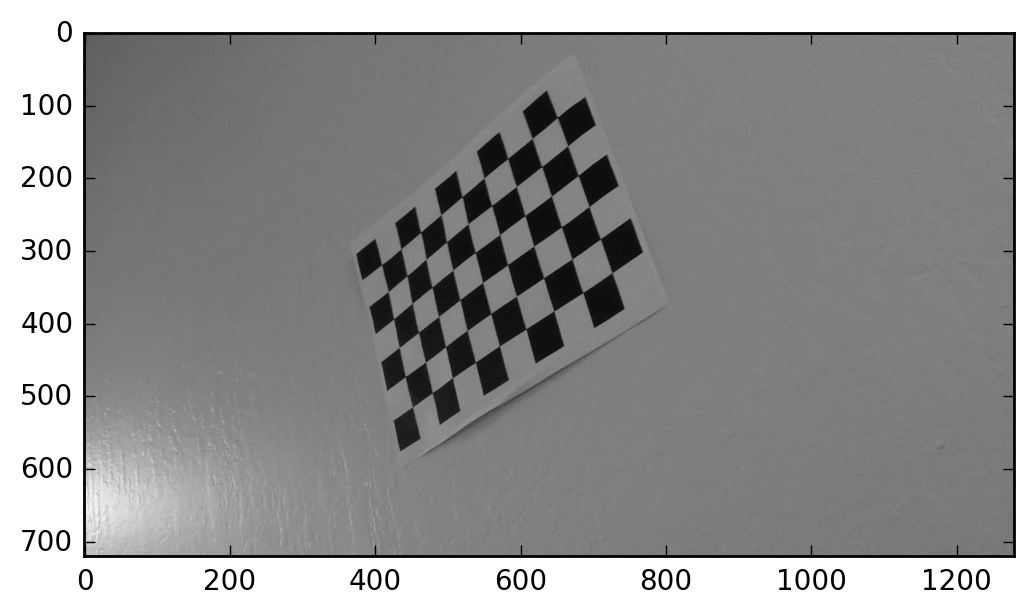

In [38]:
# quick sanity check of images:
plt.imshow(img_gray[4], cmap='gray')

In [39]:
# as can be seen from the image, the chessboard is in a 9 x 6 grid
chessgrid_size = (9,6)
object_points = np.zeros((9*6 ,3), np.float32)
object_points[:,:2] = np.mgrid[0:9, 0:6].T.reshape(-1,2)

In [46]:
# find the corners in the images with cv2 findChessboardCorners function
img_points_arr = []
obj_points_arr = []
def find_corners(img, chessgridsize):
    ret, corners = cv2.findChessboardCorners(img, chessgridsize,None)
    if ret == True:
        img_points_arr.append(corners)
        obj_points_arr.append(object_points)
        
for i in range(len(img_gray)):
    find_corners(img_gray[i], chessgrid_size)

In [54]:
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(obj_points_arr, img_points_arr, img_gray[0].shape[::-1],None,None)
# ret == return, whether cv2 can calibratie successfully, mtx == camera matrix, 
# dist== distortion, rvects/tvects==rotation vector, translation vector

In [57]:
np.save('camera_calibration.npy', {'mtx': mtx, 'dist': dist})

---

In [3]:
camera_calibration = np.load('camera_calibration.npy').item()
dist = camera_calibration['dist']
mtx = camera_calibration['mtx']

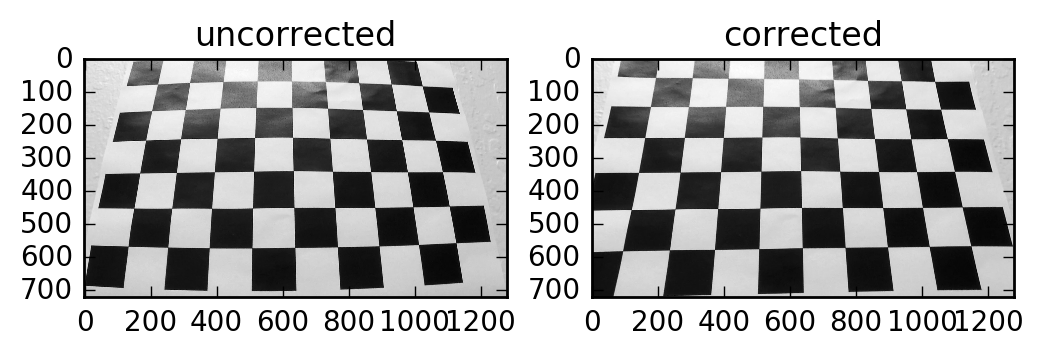

In [25]:
# undistort one of the sample images:
cal_image = img2Gray('camera_cal/calibration3.jpg')
undistorted_cal_img = cv2.undistort(cal_image, mtx, dist, None, mtx)
cv2.imwrite('output_images/calibration3_corrected.jpg',undistorted_cal_img)

ax = plt.subplot(1,2,1)
ax.set_title('uncorrected')
ax.imshow(cal_image, cmap='gray')
ax2 = plt.subplot(1,2,2)
ax2.set_title('corrected')
ax2.imshow(undistorted_cal_img, cmap='gray')
plt.savefig('output_images/calibration_test.jpg')

In [62]:
#  now undistort the test images:
test_images_fnames = glob.glob('test_images/test*.jpg')
test_images = [cv2.imread(x) for x in test_images_fnames]
undistorted = [cv2.undistort(x, mtx, dist, None, mtx) for x in test_images]

In [30]:
for idx, img in enumerate(undistorted):
    fname = test_images_fnames[idx].replace('.jpg', '').replace('test_images', 'output_images') + '_camera_corrected.jpg'
    cv2.imwrite(fname ,img)

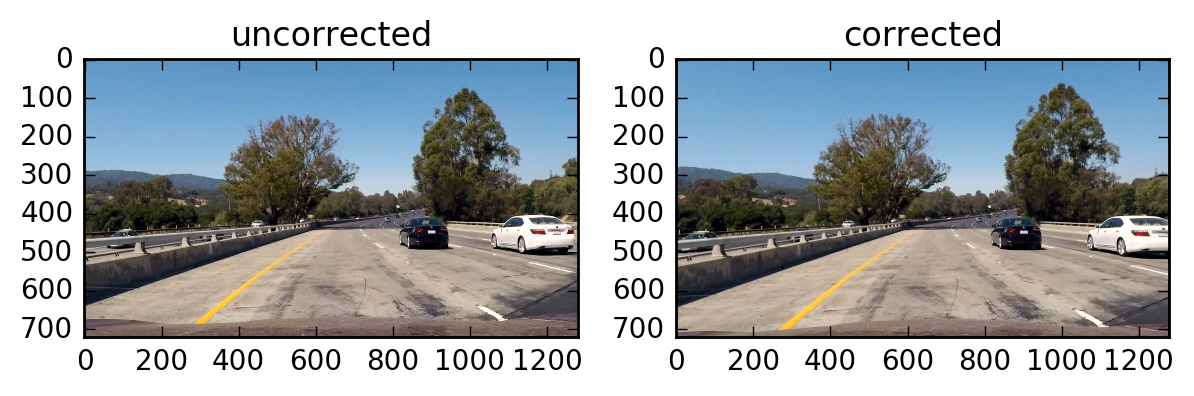

In [33]:
fig, ax0 = plt.subplots()
fig.set_size_inches(7, 4)
ax = plt.subplot(1,2,1)
ax.set_title('uncorrected')
ax.imshow(cv2.cvtColor(test_images[0], cv2.COLOR_BGR2RGB))
ax2 = plt.subplot(1,2,2)
ax2.set_title('corrected')
ax2.imshow(cv2.cvtColor(undistorted[0], cv2.COLOR_BGR2RGB))

In [34]:
plt.savefig('output_images/camera_distortion_correction.jpg')

### Thresholding

In [60]:
def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255)):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    if orient == 'x':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    else:
        sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    
    abs_sobel = np.absolute(sobel)
    scaled = np.uint8(255 * abs_sobel/np.max(abs_sobel))
    grad_binary = np.zeros_like(scaled)
    grad_binary[(scaled >= thresh[0]) & (scaled <= thresh[1])] = 1
    return grad_binary

def mag_threshold(img, sobel_kernel=3, mag_thresh=(0, 255)):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    mag = np.sqrt(np.square(sobelx) + np.square(sobely))
    scaled = np.uint8(255 * mag/np.max(mag))
    mag_binary = np.zeros_like(scaled)
    mag_binary[(scaled >= mag_thresh[0]) & (scaled <= mag_thresh[1])] = 1
    return mag_binary

def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    abs_gradient = np.arctan2(np.absolute(sobely) ,np.absolute(sobelx))
    dir_binary = np.zeros_like(abs_gradient)
    dir_binary[(abs_gradient >= thresh[0]) & (abs_gradient <= thresh[1])] = 1
    return dir_binary



In [63]:
sksize = 3
threshx = (15,90)
threshy = (20, 90)
mag_thresh = (30,100)
dir_thresh = (0.7, 1.3)
img = undistorted[2]
# def combined_threshold(image, sobel_kernel=3, threshx=(0, 255), threshy=(0,255),
#                        mag_thresh = (0, 255), dir_thresh = (0, np.pi/2)):
gradx = abs_sobel_thresh(img, orient='x', sobel_kernel=sksize, thresh=threshx)
grady = abs_sobel_thresh(img, orient='y', sobel_kernel=sksize, thresh=threshy)
mag_binary = mag_threshold(img, sobel_kernel=sksize, mag_thresh=mag_thresh)
dir_binary = dir_threshold(img, sobel_kernel=sksize, thresh = dir_thresh)


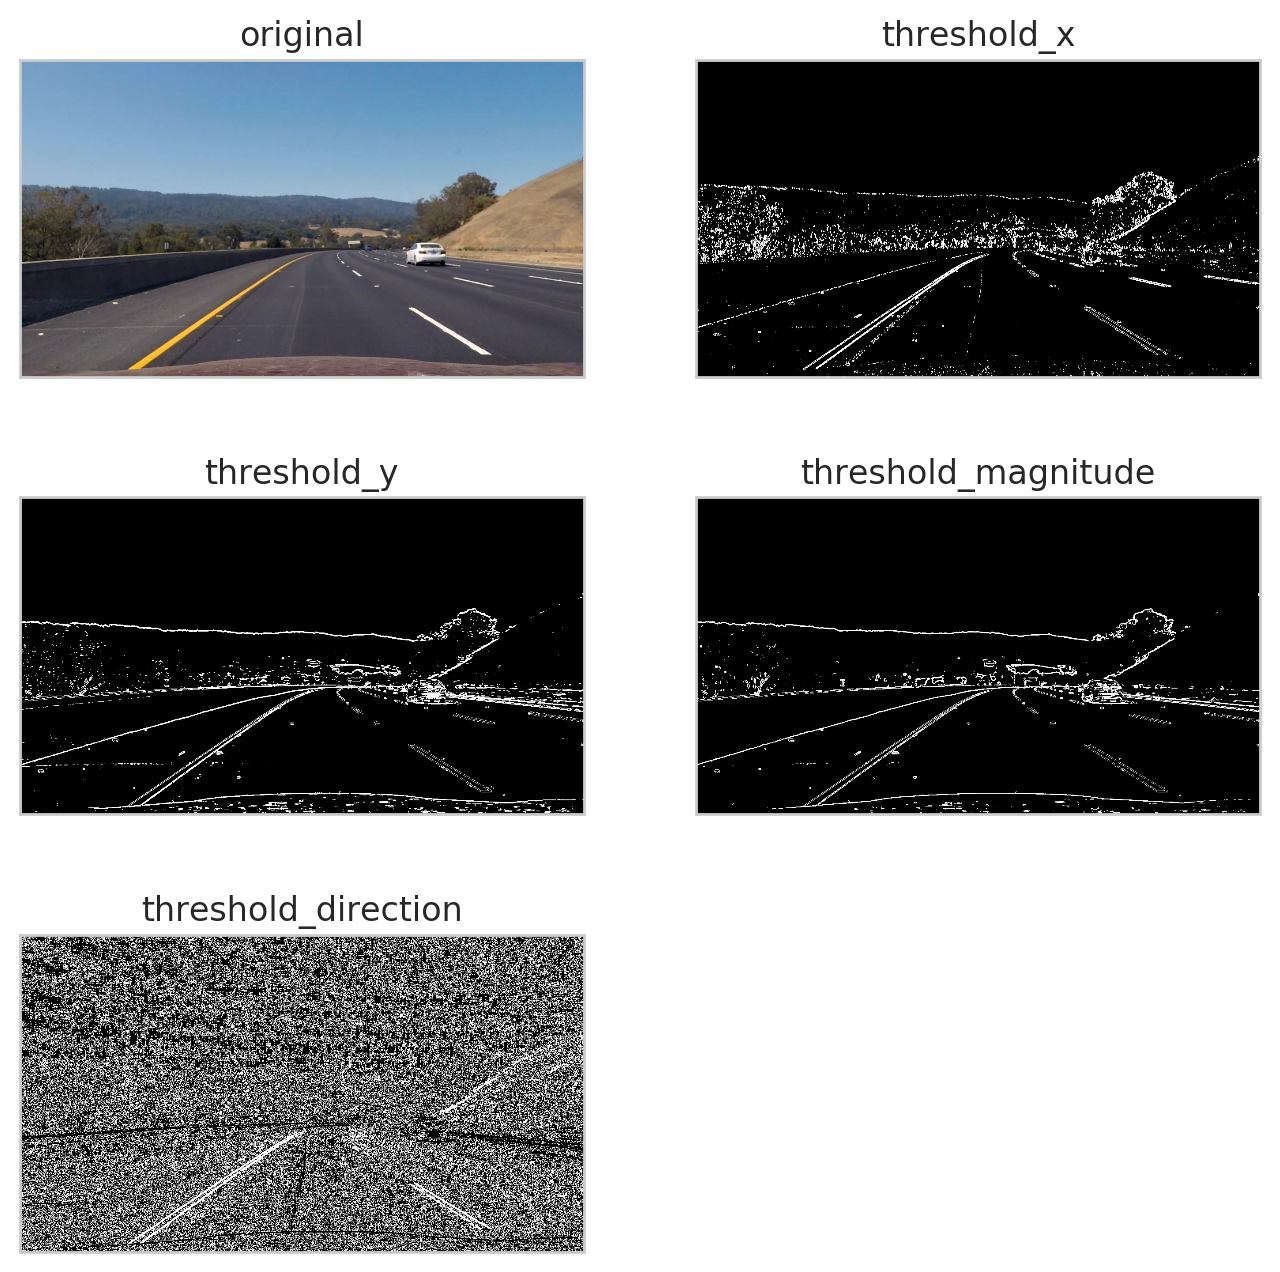

In [126]:
images_to_plot = [cv2.cvtColor(img, cv2.COLOR_BGR2RGB), gradx, grady, mag_binary, dir_binary]
titles = ['original', 'threshold_x', 'threshold_y', 'threshold_magnitude', 'threshold_direction']
fig = plt.figure(figsize=(8, 8))
for idx, currimg in enumerate(images_to_plot):
    ax = fig.add_subplot(3,2, idx +1)
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
    ax.set_title(titles[idx])
    ax.grid(False)
    if(idx == 0):
        ax.imshow(currimg)
    else:
        ax.imshow(currimg, cmap='gray')


In [127]:
plt.savefig('test_images/thresholding.jpg')

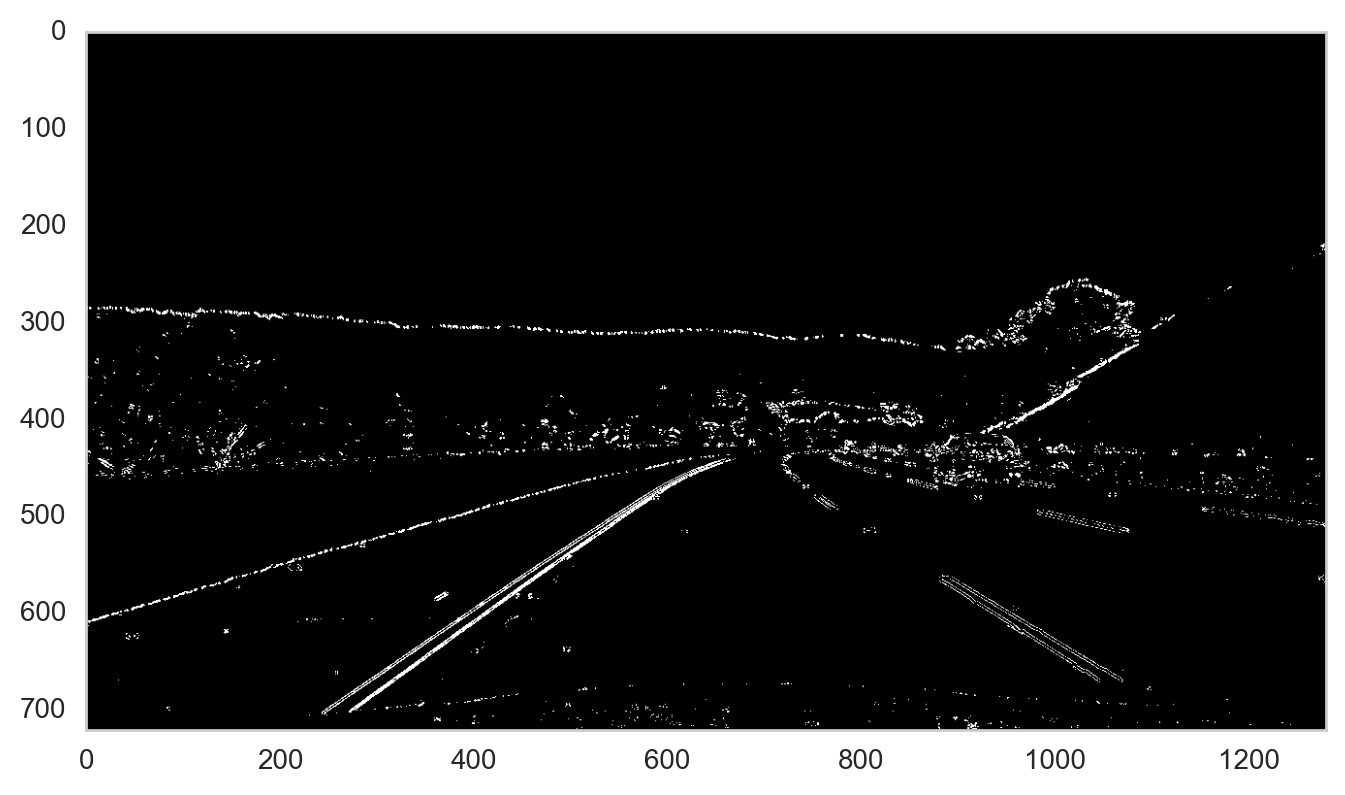

In [68]:
combined = np.zeros_like(dir_binary)
combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1
# combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1)) & (dir_binary == 1)] = 1
plt.grid(False)
plt.imshow(combined, cmap='gray')

In [64]:
def color_threshold(img, thresh=(0,255)):
    hls = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
    s_channel = hls[:,:,2]
    binary_output = np.zeros_like(s_channel)
    binary_output[(s_channel >= thresh[0]) & (s_channel <= thresh[1])] = 1
    return binary_output

In [65]:
color_binary = color_threshold(img, thresh=(70,255))

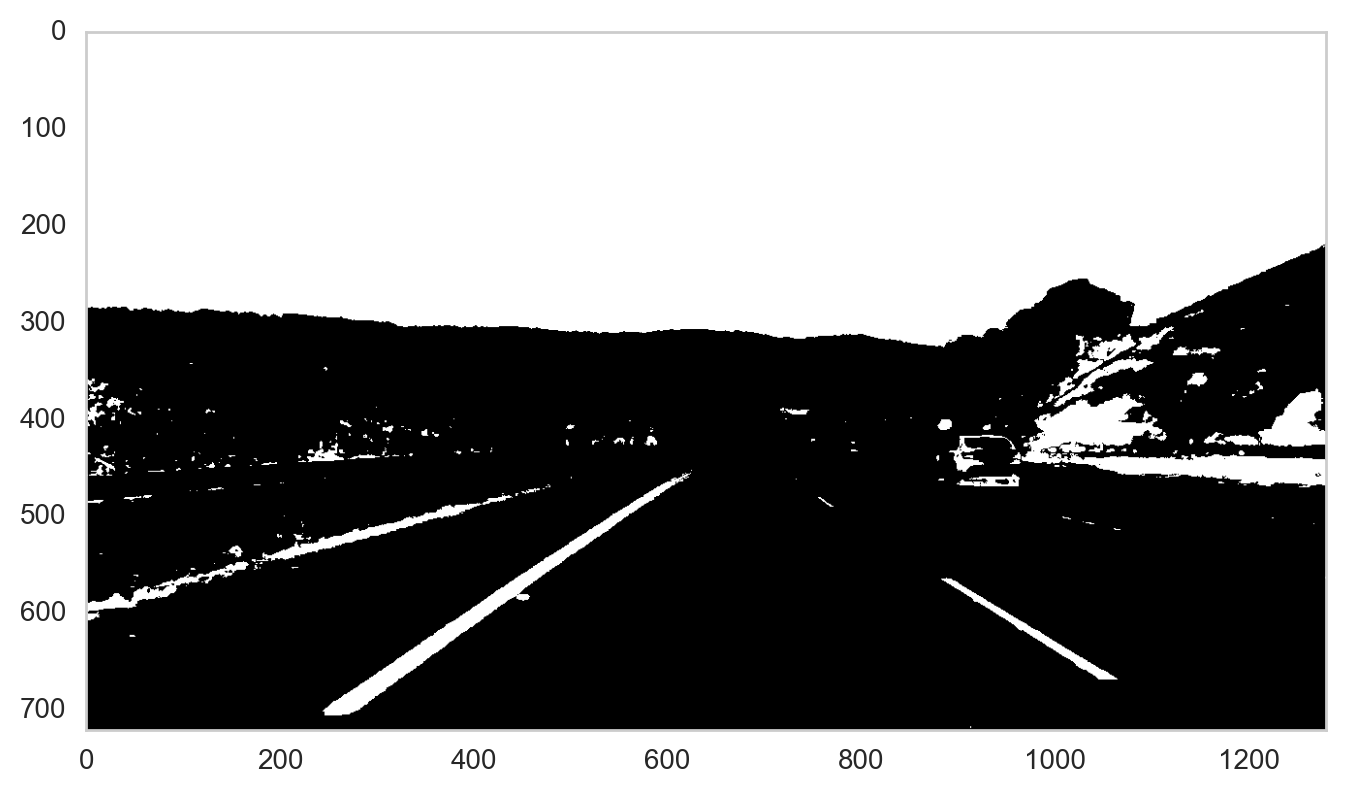

In [66]:
plt.grid(False)
plt.imshow(color_binary, cmap='gray')

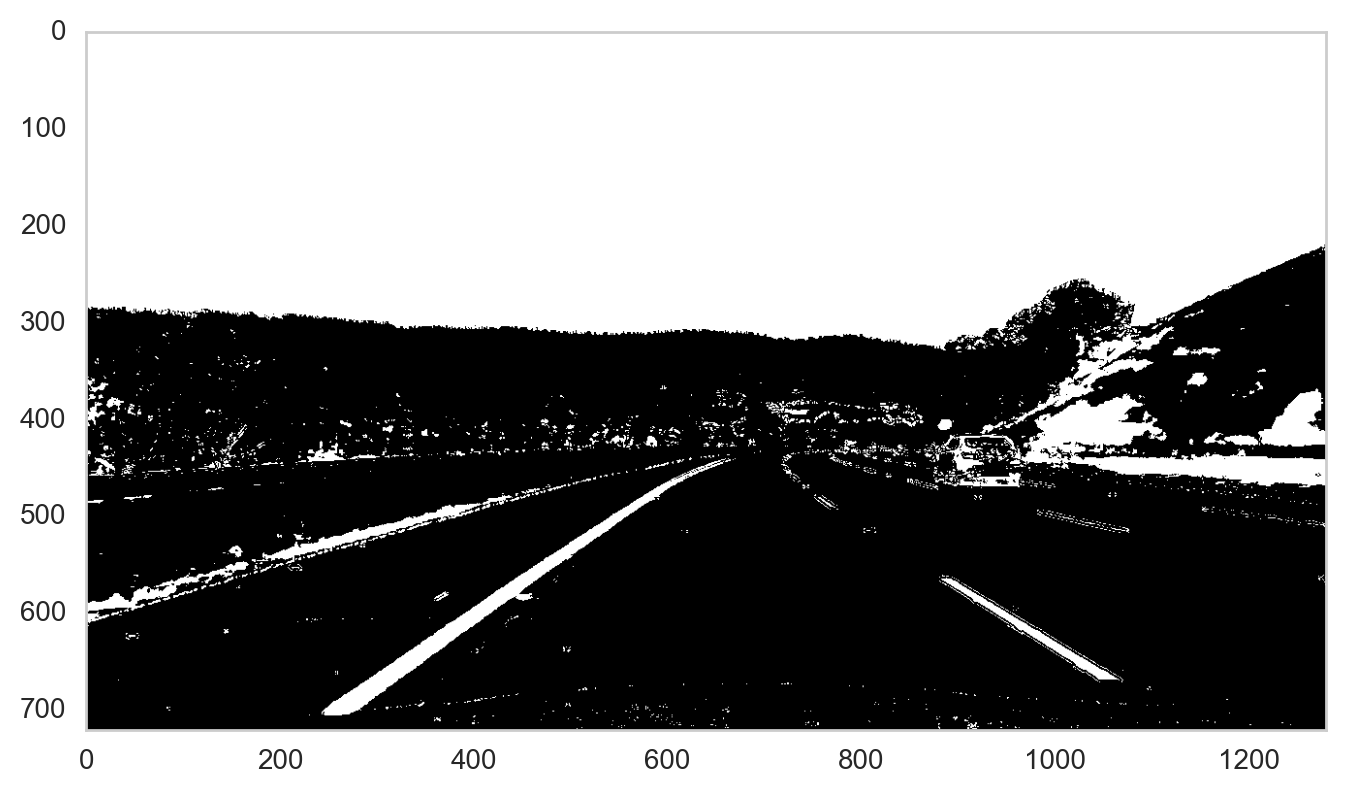

In [69]:
# this combination seems to have detected the lines most strongly
combined2 = np.zeros_like(combined)
combined2[(combined == 1) | (color_binary == 1)] = 1
# combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1)) & (dir_binary == 1)] = 1
plt.grid(False)
plt.imshow(combined2, cmap='gray')

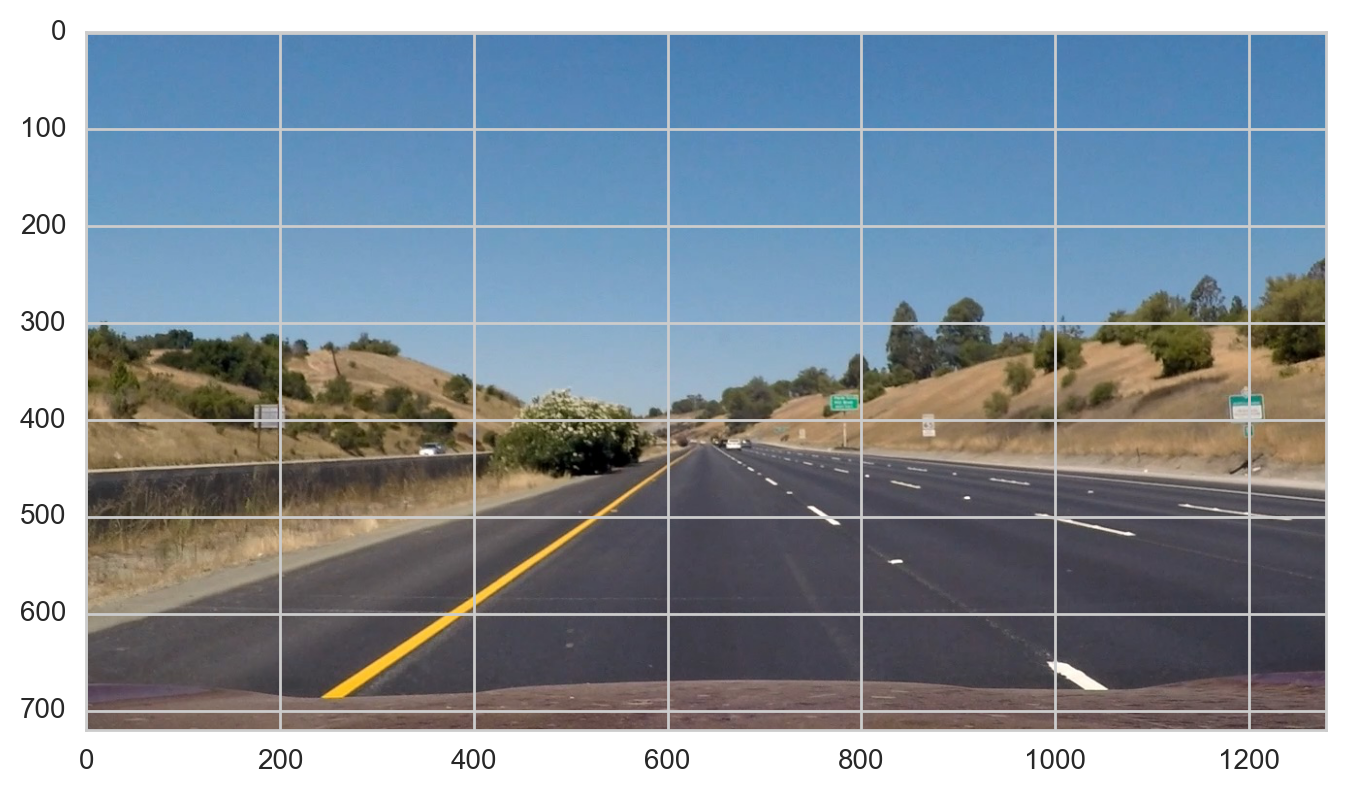

In [4]:
# perspective transform
straightlines = cv2.cvtColor(cv2.imread('test_images/straight_lines1.jpg'), cv2.COLOR_BGR2RGB)
plt.imshow(straightlines)

In [36]:
def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    """    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    for line in lines:
        x1 = line[0]
        y1 = line[1]
        x2 = line[2]
        y2 = line[3]
#         for x1,y1,x2,y2 in line:
        cv2.line(img, (x1, y1), (x2, y2), color, thickness)
    return img




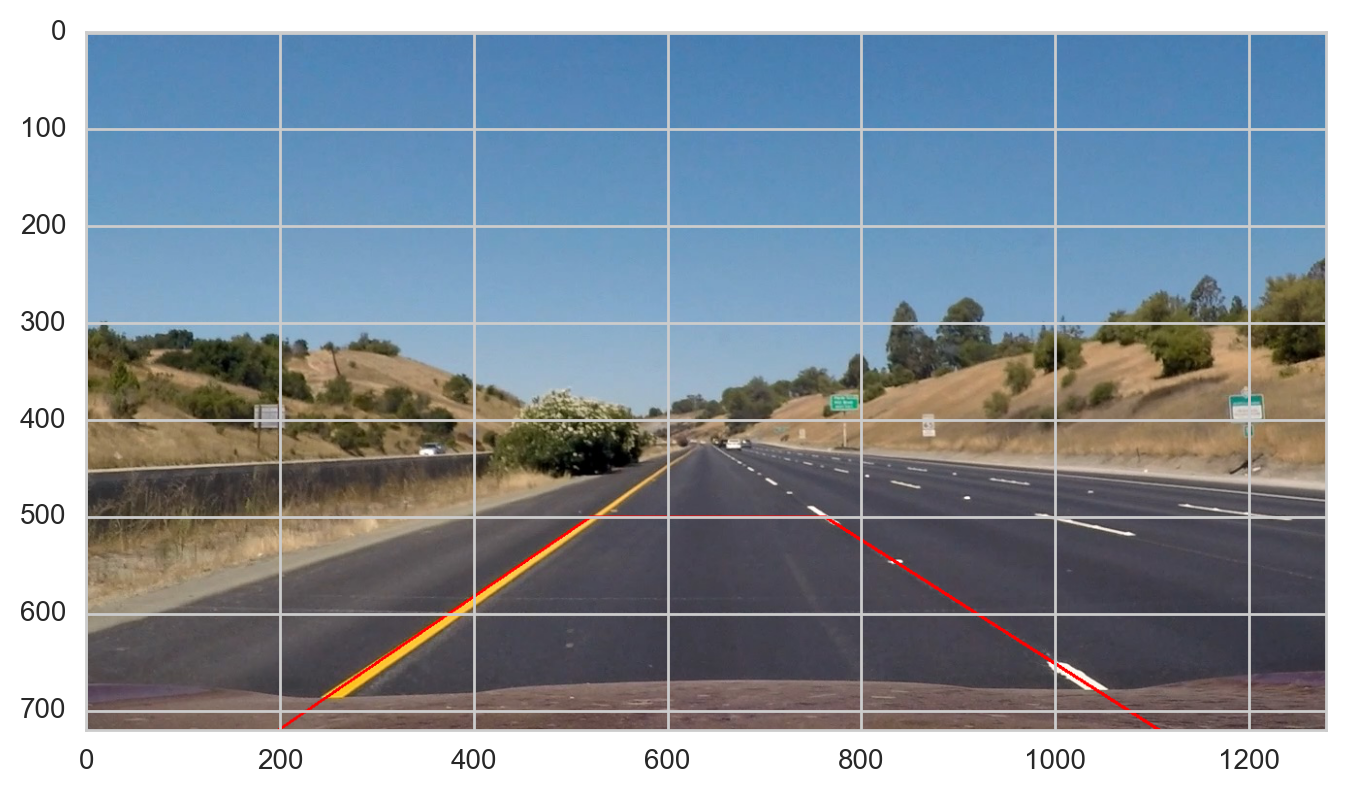

In [51]:
corners = [[190, 725], [520,500], [762,500], [1115, 725]]
lines_arr = [corners[0]+ corners[1],corners[1]+corners[2] ,corners[2]+ corners[3],corners[3]+corners[0]]
lines_output = draw_lines(np.copy(straightlines), lines_arr)
plt.imshow(lines_output)

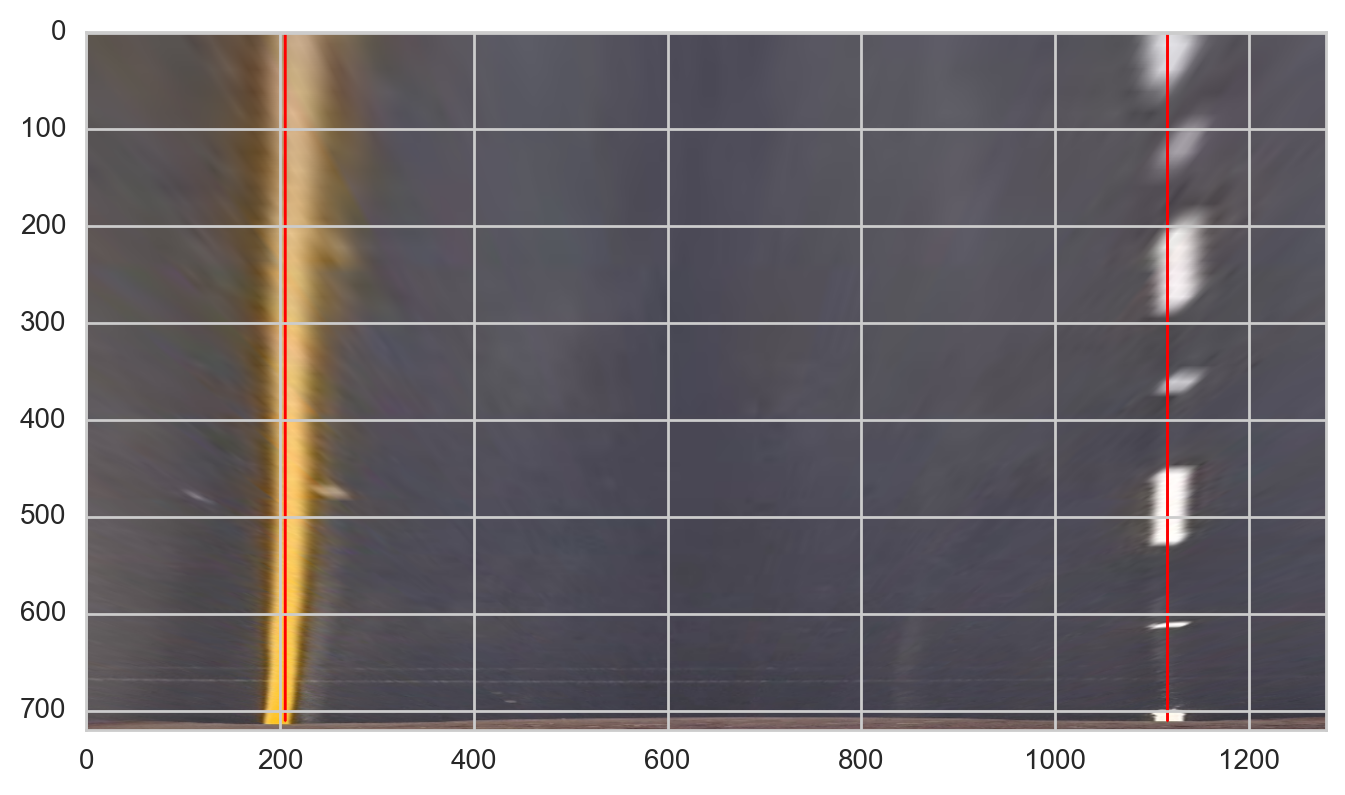

In [57]:
dst_corners = [[190, 725], [190,500], [1115,500], [1115, 725]]
M = cv2.getPerspectiveTransform(np.float32(corners), np.float32(dst_corners))
warped = cv2.warpPerspective(straightlines, M, (straightlines.shape[1], straightlines.shape[0]), flags=cv2.INTER_LINEAR)
warped_lines = [[205,710, 205,0], [1115, 710, 1115, 0]]
plt.imshow(draw_lines(warped, warped_lines))

In [58]:
np.save('perspective_transform_matrix.npy', M)
plt.savefig('output_images/perspective_transform.jpg')

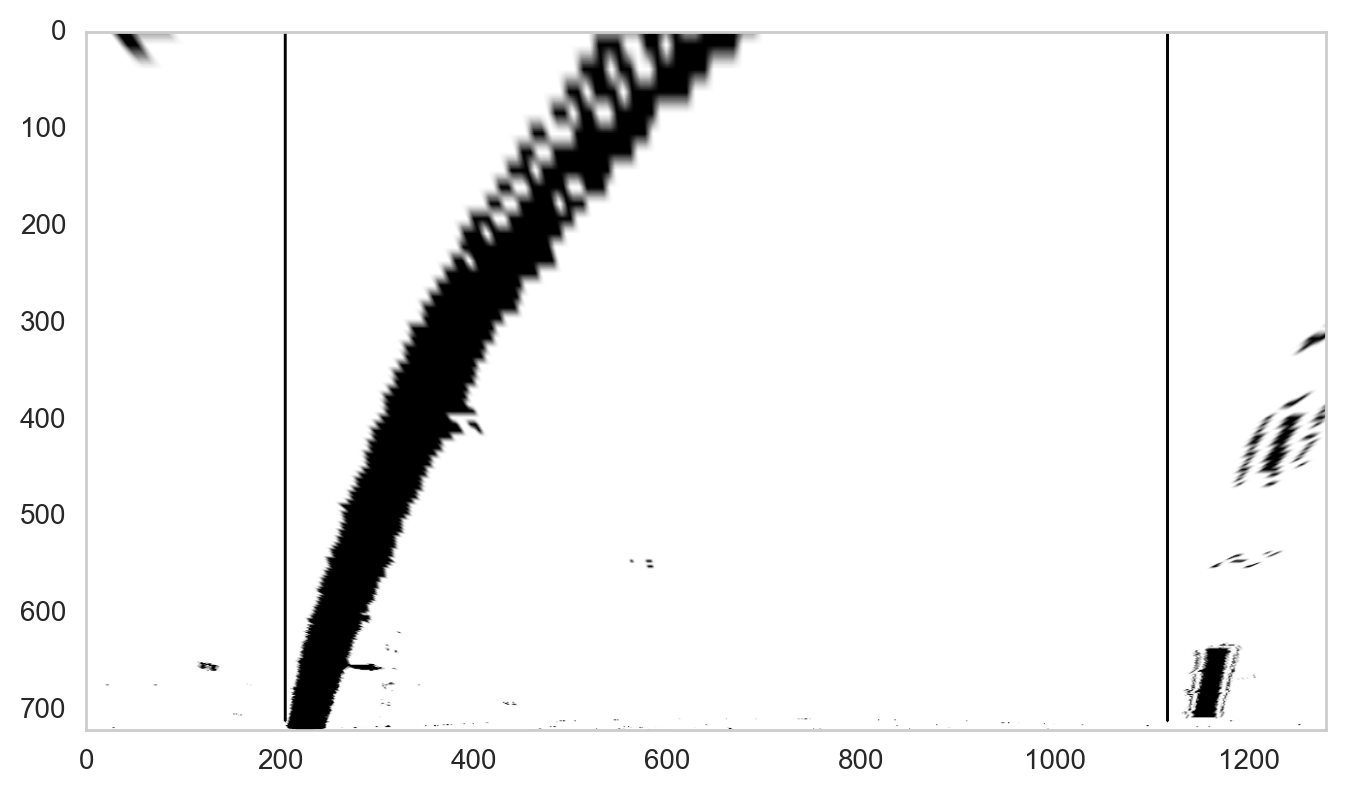

In [87]:
# thresholded_combined2 = cv2.cvtColor(255 * combined2, cv2.COLOR_GRAY2RGB)
# plt.imshow(thresholded_combined2)
warped_thresholded = cv2.warpPerspective(255 * combined2, M, (combined2.shape[1], combined2.shape[0]), flags=cv2.INTER_LINEAR)
# ax = plt.subplot(1,2,1)
# ax.imshow(draw_lines(thresholded_combined2, lines_arr))
# ax2 = plt.subplot(1,2,2)
plt.grid(False)
plt.imshow(draw_lines(np.copy(warped_thresholded), warped_lines))

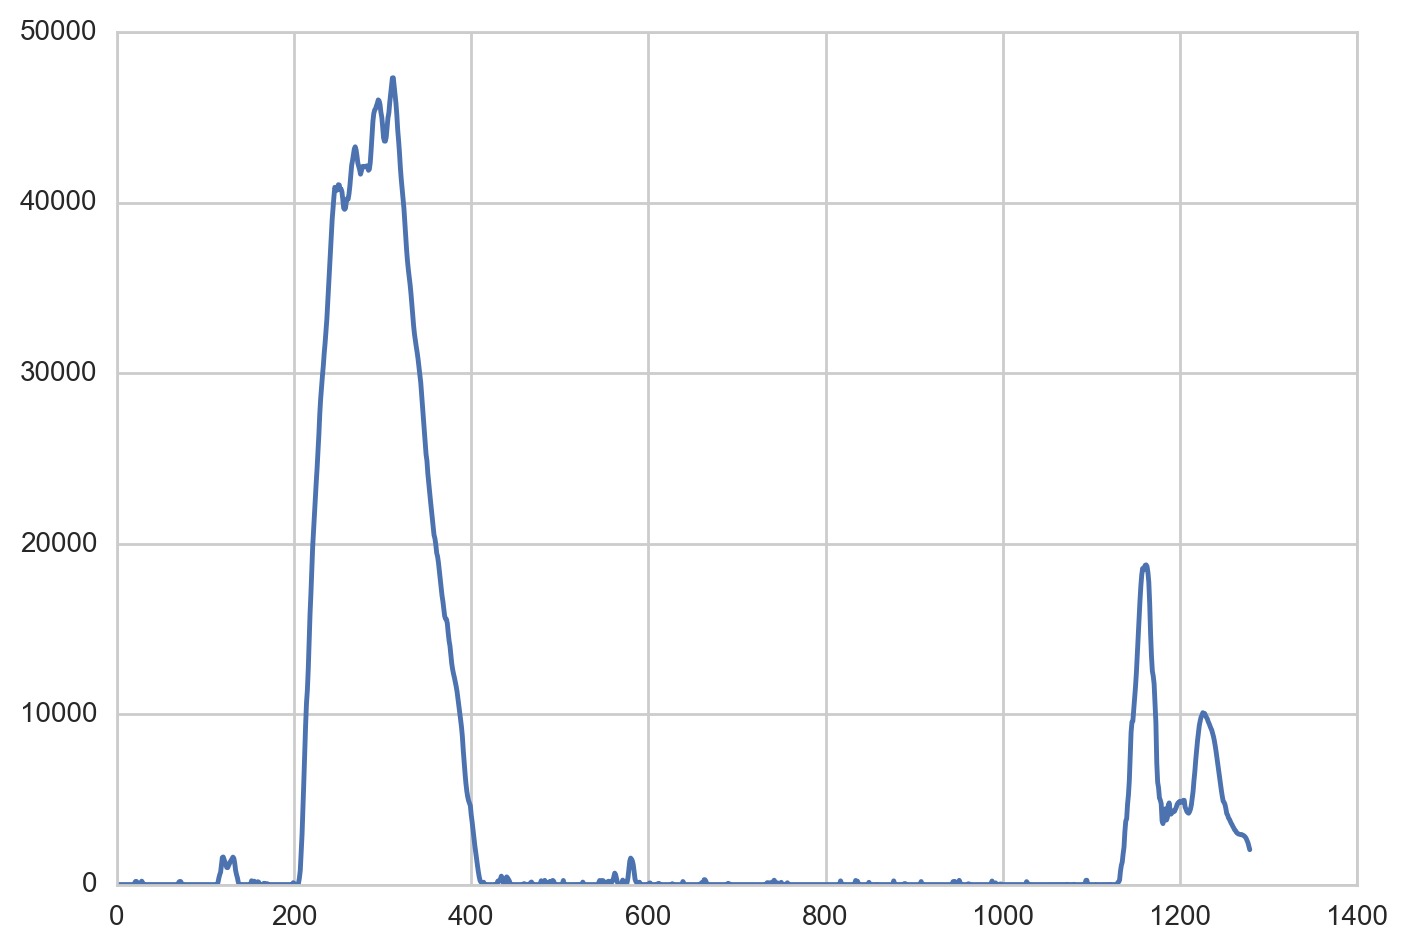

In [100]:
histogram = np.sum(warped_thresholded[warped_thresholded.shape[0]//2:,:], axis=0)
plt.plot(histogram)

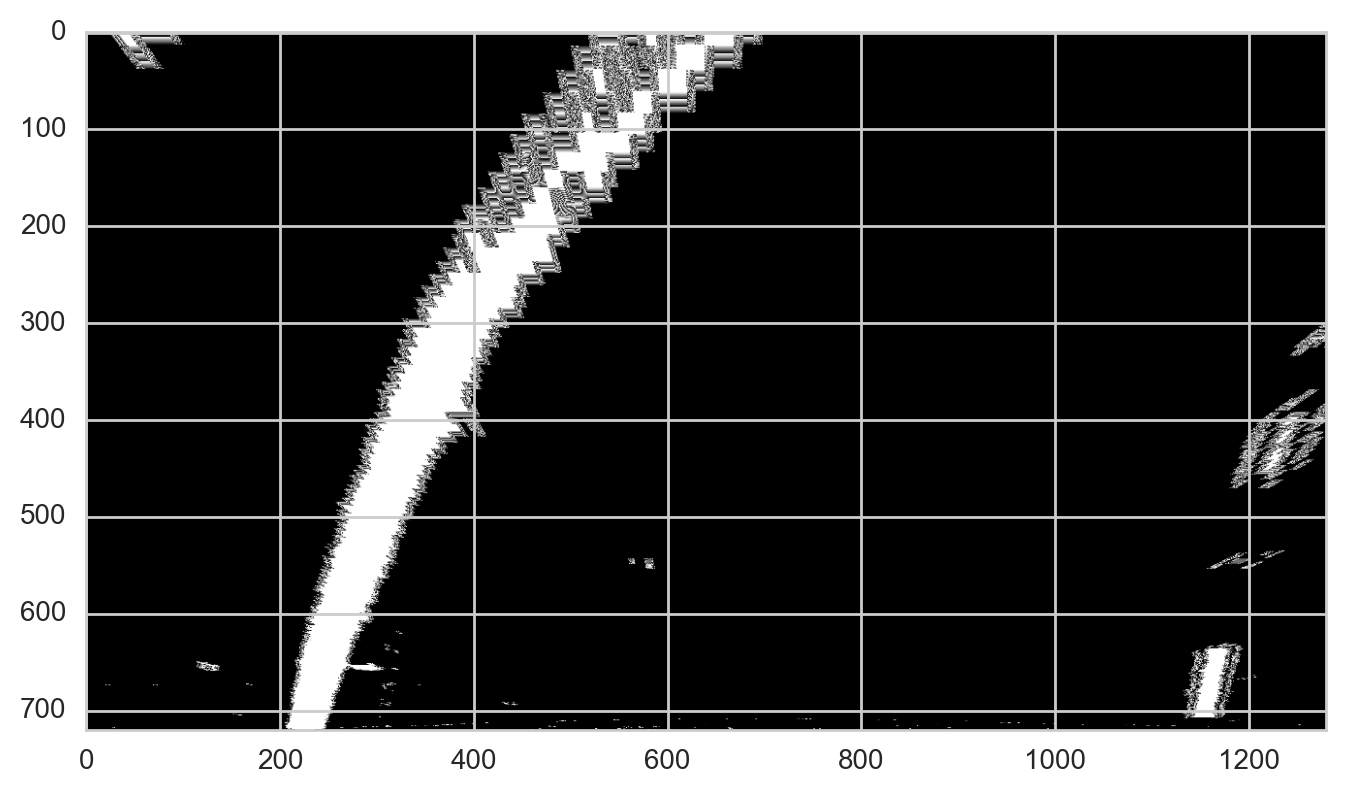

In [89]:
out_img = np.dstack((warped_thresholded, warped_thresholded, warped_thresholded)) * 255
plt.imshow(out_img)

In [102]:
midpoint = np.int(histogram.shape[0]/2)
left_x = np.argmax(histogram[:midpoint])
right_x = np.argmax(histogram[midpoint:]) + midpoint

nwindows = 15
window_height = np.int(warped_thresholded.shape[0] / nwindows)
nonzero = warped_thresholded.nonzero()
nonzero_x = np.array(nonzero[1])
nonzero_y = np.array(nonzero[0])

In [92]:
leftx_curr = left_x
rightx_curr = right_x

margin= 100
minpix =50

leftlaneidx = []
rightlaneidx = []


In [141]:
for i in range(nwindows):
    #get coordinates of the windows
    win_y_bottom = warped_thresholded.shape[0] - (i + 1) * window_height
    win_y_top = warped_thresholded.shape[0] - i * window_height
    win_x_left_low = leftx_curr - margin
    win_x_left_high = leftx_curr + margin
    win_x_right_low = rightx_curr - margin
    win_x_right_high = rightx_curr + margin
    
    cv2.rectangle(out_img, (win_x_left_low, win_y_bottom), (win_x_left_high, win_y_top), (0,255,0), 12)
    cv2.rectangle(out_img, (win_x_right_low, win_y_bottom), (win_x_right_high, win_y_top), (0,255,0), 12)
    
    left_indexes = ((nonzero_y >= win_y_bottom) & (nonzero_y < win_y_top) & 
                    (nonzero_x >= win_x_left_low) & (nonzero_x < win_x_left_high)).nonzero()[0]
    right_indexes = ((nonzero_y >= win_y_bottom) & (nonzero_y < win_y_top) & 
                    (nonzero_x > win_x_right_low) & (nonzero_x < win_x_right_high)).nonzero()[0]
    

    leftlaneidx.append(left_indexes)
    rightlaneidx.append(right_indexes)
    
    if len(left_indexes) > minpix:
        leftx_curr = np.int(np.mean(nonzero_x[left_indexes]))
    if len(right_indexes) > minpix:
        rightx_curr = np.int(np.mean(nonzero_x[right_indexes]))

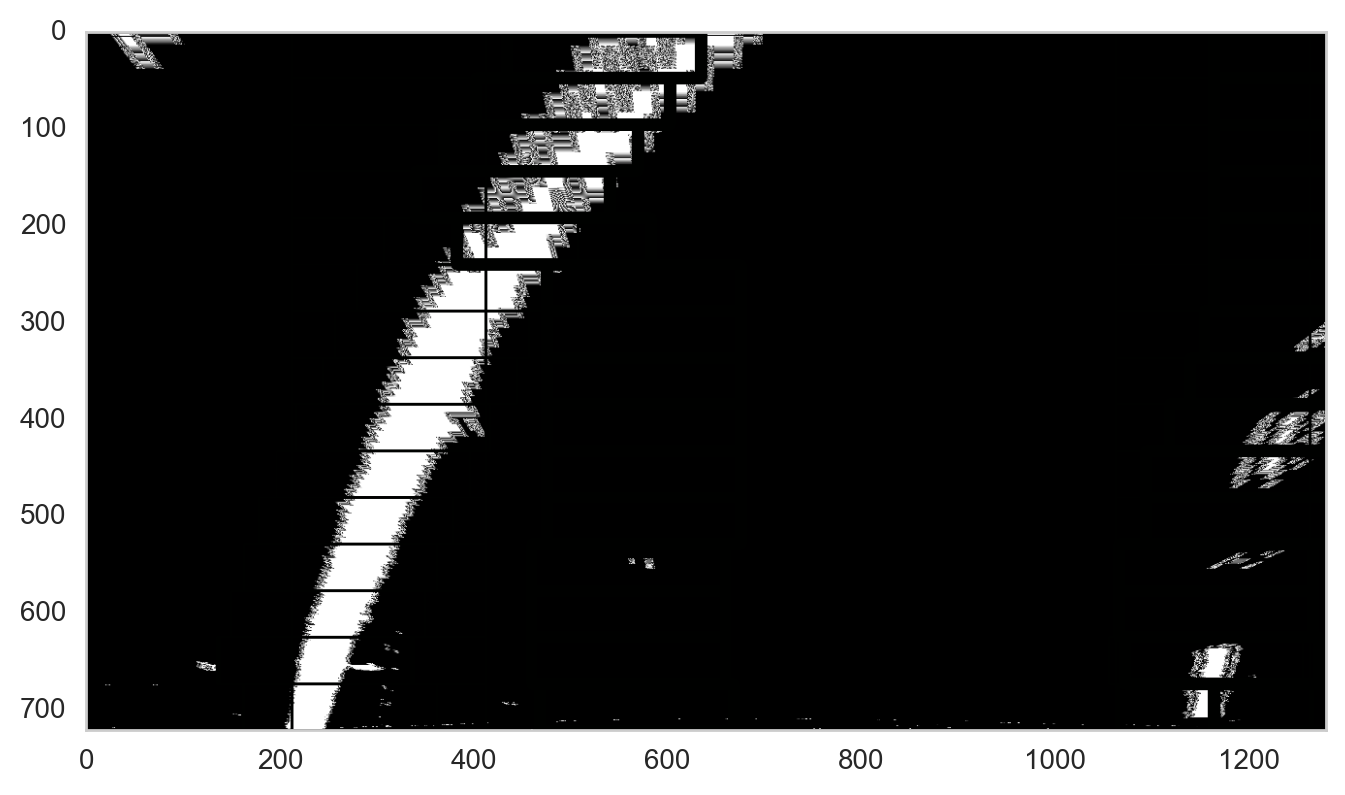

In [144]:
plt.grid(False)
plt.imshow(out_img)

In [125]:
leftx = nonzero_x[np.concatenate(leftlaneidx)]
lefty = nonzero_y[np.concatenate(leftlaneidx)] 
rightx = nonzero_x[np.concatenate(rightlaneidx)]
righty = nonzero_y[np.concatenate(rightlaneidx)] 

# Fit a second order polynomial to each
left_polyfit = np.polyfit(lefty, leftx, 2)
right_polyfit = np.polyfit(righty, rightx, 2)

In [130]:
plotvals = np.linspace(0, warped_thresholded.shape[0] - 1, warped_thresholded.shape[0])

In [133]:
left_xvals = left_polyfit[2] + left_polyfit[1] * plotvals + left_polyfit[0] * plotvals **2
right_xvals = right_polyfit[2] + right_polyfit[1] * plotvals + right_polyfit[0] * plotvals **2

ValueError: x and y must have same first dimension

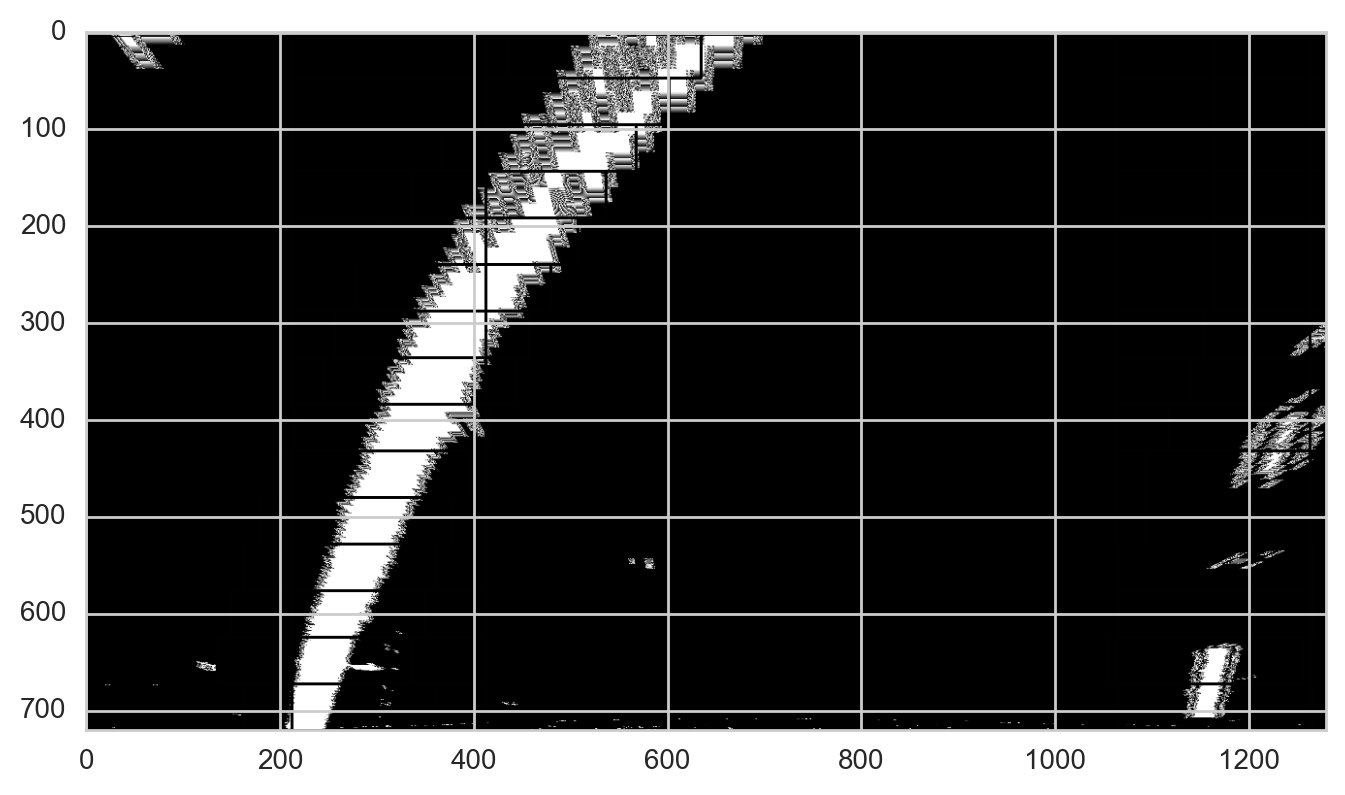

In [136]:
out_img[nonzero_y[leftx], nonzero_x[leftx]] = [255, 0, 0]
out_img[nonzero_y[rightx], nonzero_x[rightx]] = [0, 0, 255]
plt.imshow(out_img)
plt.plot(left_polyfit, plotvals, color='yellow')
plt.plot(right_polyfit, plotvals, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)